In [1]:
import numpy as np
import matplotlib.pyplot as plt
import saqqara
from simulator import LISA_AET
import glob
import torch
import swyft
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler
from pytorch_lightning import loggers as pl_loggers

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Find data files and check them

In [2]:
DATA_DIR = "./simulations/"
Z_FILES = glob.glob(DATA_DIR + "/z_*.npy")
Z_FILES = sorted(Z_FILES, key=lambda x: str(x.split("_")[-1].split(".")[0]))
DATA_FILES = glob.glob(DATA_DIR + "/cg_data_*.npy")
DATA_FILES = sorted(DATA_FILES, key=lambda x: str(x.split("_")[-1].split(".")[0]))

# Check all names match
for idx in range(len(Z_FILES)):
    assert (
        Z_FILES[idx].split("_")[-1].split(".")[0]
        == DATA_FILES[idx].split("_")[-1].split(".")[0]
    )

# Compute total number of simulations
n_simulations = len(Z_FILES) * 128
print(f"Total number of simulations: {n_simulations}")

# Get data shapes
z_shape = np.load(Z_FILES[0]).shape[1:]
data_shape = np.load(DATA_FILES[0]).shape[1:]
print(f"z shape: {z_shape}")
print(f"data shape: {data_shape}")

Total number of simulations: 500736
z shape: (4,)
data shape: (945, 3)


### Load simulator and config

In [3]:
config = saqqara.load_settings("default_config.yaml")
sim = LISA_AET(config)

Detector setup complete


Noise matrices computed
Response computed
Coarse graining setup complete


### Construct datasets and dataloaders

In [4]:
z_dataset = saqqara.NPYDataset(file_paths=Z_FILES)
data_dataset = saqqara.NPYDataset(file_paths=DATA_FILES)

In [5]:
# Check the dataset loading
z_batch = z_dataset[:100]
data_batch = data_dataset[:100]
print("z_batch shape:", z_batch.shape)
print("data_batch shape:", data_batch.shape)

z_batch shape: torch.Size([100, 4])
data_batch shape: torch.Size([100, 945, 3])


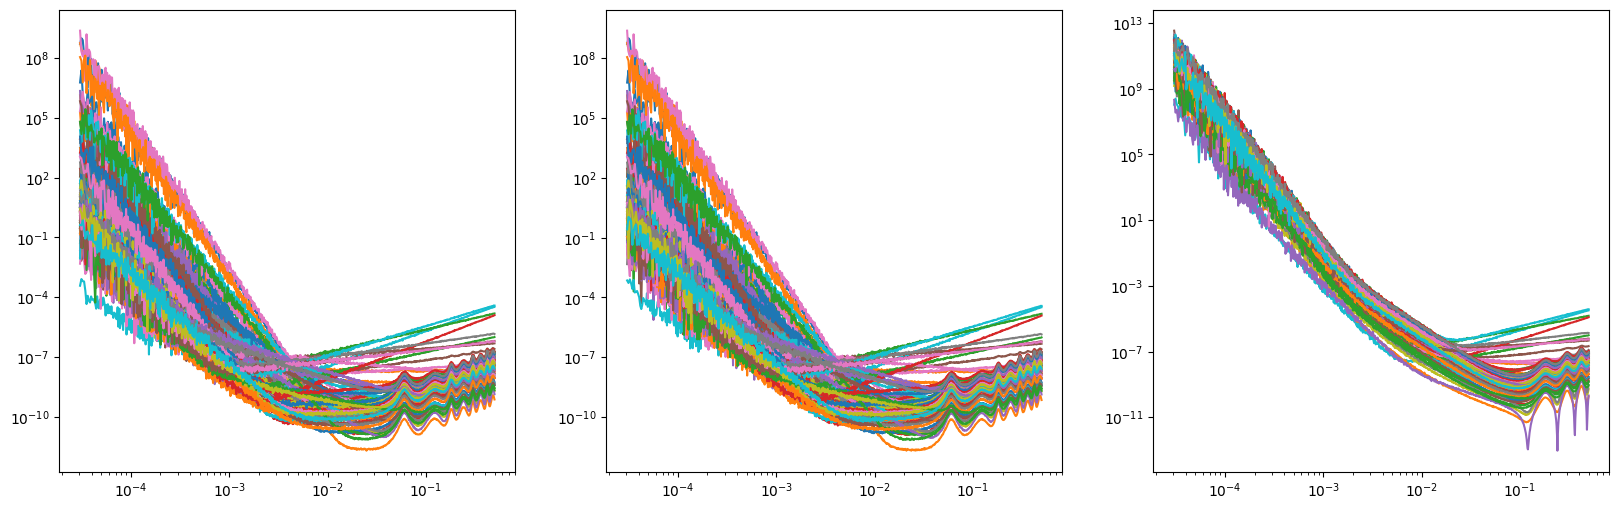

In [6]:
fig = plt.figure(figsize=(20, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.loglog(sim.coarse_grained_f, data_batch[:, :, i].T)

In [7]:
training_dataset = saqqara.TrainingDataset(z_store=z_dataset, data_store=data_dataset)

In [8]:
# Dataset properties
print("Training dataset properties:")
print("length:", len(training_dataset))
print("z shape:", training_dataset["z"][0].shape)
print("data shape:", training_dataset["data"][0].shape)

Training dataset properties:
length: 500736
z shape: torch.Size([4])
data shape: torch.Size([945, 3])


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/saqqara/data.py:45: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(data).float()


In [9]:
def setup_dataloaders(
    dataset,
    total_size=None,
    train_fraction=0.8,
    val_fraction=0.2,
    num_workers=0,
    batch_size=64,
):
    if total_size is None:
        total_size = len(dataset)
    indices = list(range(len(dataset)))
    train_idx, val_idx = int(np.floor(train_fraction * total_size)), int(
        np.floor((train_fraction + val_fraction) * total_size)
    )
    train_indices, val_indices = indices[:train_idx], indices[train_idx:val_idx]
    # train_sampler, val_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)
    train_sampler, val_sampler = SequentialSampler(train_indices), SequentialSampler(
        val_indices
    )
    train_dataloader = DataLoader(
        dataset=dataset,
        drop_last=True,
        sampler=train_sampler,
        num_workers=int(num_workers),
        batch_size=int(batch_size),
    )
    val_dataloader = DataLoader(
        dataset=dataset,
        drop_last=True,
        sampler=val_sampler,
        num_workers=int(num_workers),
        batch_size=int(batch_size),
    )
    return train_dataloader, val_dataloader

In [10]:
train_dl, val_dl = setup_dataloaders(training_dataset, total_size=50_000, num_workers=10, batch_size=64)

### Setup networks and trainer

In [11]:
from swyft.networks import OnlineStandardizingLayer
from swyft.networks import ResidualNetWithChannel


class InferenceNetwork(swyft.SwyftModule, swyft.AdamWReduceLROnPlateau):
    def __init__(self, sim=None):
        super().__init__()
        self.sim = sim
        self.learning_rate = 1e-4
        self.num_feat_param = 3  # Number of channels
        self.num_params = 4
        self.npts = sim.coarse_grained_f.shape[0]
        self.nl_AA = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_EE = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_TT = OnlineStandardizingLayer(shape=(self.npts,))
        self.resnet = ResidualNetWithChannel(
            channels=3,
            in_features=self.npts,
            out_features=self.num_params,
            hidden_features=64,
            num_blocks=4,
            dropout_probability=0.1,
            use_batch_norm=True,
        )
        self.fc_AA = torch.nn.Linear(self.npts, sim.nparams)
        self.fc_EE = torch.nn.Linear(self.npts, sim.nparams)
        self.fc_TT = torch.nn.Linear(self.npts, sim.nparams)
        self.marginals = self.get_marginals(sim.nparams)
        self.lrs1d = swyft.LogRatioEstimator_1dim(
            num_features=self.num_feat_param,
            num_params=self.num_params,
            varnames="z",
        )
        self.lrs2d = swyft.LogRatioEstimator_Ndim(
            num_features=2 * self.num_feat_param,
            marginals=self.marginals,
            varnames="z",
        )

    def forward(self, A, B):
        log_data = torch.log(A["data"])
        # reshape to (batch, num_channels, num_freqs)
        log_data = log_data.transpose(1, 2)
        norm_AA = self.nl_AA(log_data[..., 0, :])
        norm_EE = self.nl_EE(log_data[..., 1, :])
        norm_TT = self.nl_TT(log_data[..., 2, :])

        full_data = torch.stack([norm_AA, norm_EE, norm_TT], dim=-2)

        compression = self.resnet(full_data)
        s1 = compression.reshape(
            -1, self.num_params, self.num_feat_param
        )  # (batch, num_params, num_feat_param)
        s2 = torch.stack(
            [torch.cat([s1[:, i, :], s1[:, j, :]], dim=-1) for i, j in self.marginals],
            dim=1,
        )
        lrs1d = self.lrs1d(s1, B["z"])
        lrs2d = self.lrs2d(s2, B["z"])
        return lrs1d, lrs2d

    @staticmethod
    def get_marginals(n_params):
        marginals = []
        for i in range(n_params):
            for j in range(n_params):
                if j > i:
                    marginals.append((i, j))
        return tuple(marginals)

In [12]:
run_counter = 1

In [13]:
logger = pl_loggers.WandbLogger(
    offline=False,
    name=f"test_50k",
    project="saqqara",
    entity="j-b-g-alvey",
    log_model="all",
    config=config,
)
device = "gpu" if torch.cuda.is_available() else "cpu"
trainer = swyft.SwyftTrainer(accelerator=device, max_epochs=100, logger=logger)
network = InferenceNetwork(sim=sim)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: j-b-g-alvey. Use `wandb login --relogin` to force relogin


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
run_counter += 1
trainer.fit(network, train_dl, val_dl)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type                     | Params
------

Sanity Checking: 0it [00:00, ?it/s]

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0:  80%|████████  | 625/781 [00:17<00:04, 35.98it/s, loss=-9.91, v_num=02gw]  

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 36: 100%|██████████| 781/781 [00:21<00:00, 36.66it/s, loss=-12, v_num=02gw, val_loss=-11.6]  
Reloading best model: ./saqqara/q74u02gw/checkpoints/epoch=31-step=20000.ckpt


### Test on some observations

In [32]:
prior_samples = sim.sample(100_000, targets=["z"])

100%|██████████| 100000/100000 [00:01<00:00, 82734.94it/s]


In [36]:
observation = sim.sample(conditions={"z": np.array([-11.0, 0.0, np.random.normal(3., 0.6), np.random.normal(15., 3.)])})
observation["data"] = torch.tensor(observation["coarse_grained_data"])
dict_keys = list(observation.keys())
for k in dict_keys:
    if k not in ["z", "data"]:
        observation.pop(k)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)


In [37]:
logratios = trainer.infer(network, observation, prior_samples)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 104.95it/s]


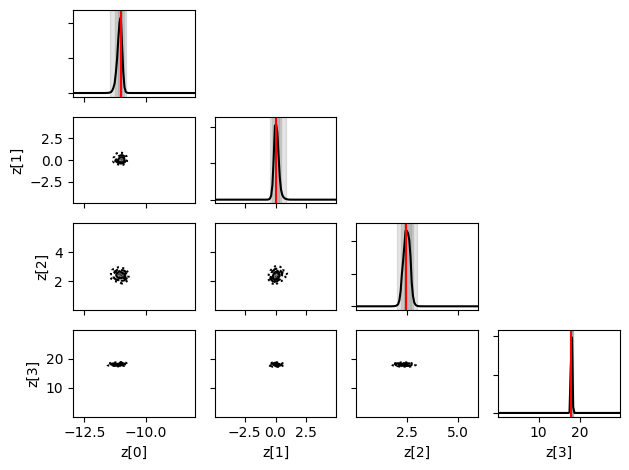

In [38]:
swyft.plot_corner(logratios, parnames=[f"z[{idx}]" for idx in range(4)]);
for j in range(4):
    ax = plt.subplot(4, 4, 4 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")

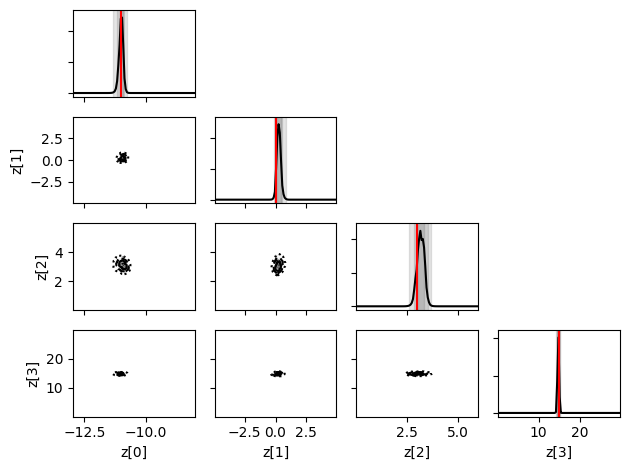

In [18]:
swyft.plot_corner(logratios, parnames=[f"z[{idx}]" for idx in range(4)]);
for j in range(4):
    ax = plt.subplot(4, 4, 4 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")

In [20]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

def compute_stats(logratios):
    values = logratios[0].params[:, :, 0].numpy()
    weights = np.exp(logratios[0].logratios.numpy())
    print("\t\t mean\t\t std")
    for j in range(4):
        mean, std = weighted_avg_and_std(values[:, j], weights[:, j])
        print(f"Parameter {j}:\t", mean, "\t", std)


In [27]:
compute_stats(logratios)

		 mean		 std
Parameter 0:	 -11.067741 	 0.09108587
Parameter 1:	 0.056141146 	 0.1678462
Parameter 2:	 3.1253319 	 0.17937312
Parameter 3:	 14.953231 	 0.15695485


In [26]:
compute_stats(logratios)

		 mean		 std
Parameter 0:	 -11.067741 	 0.09108587
Parameter 1:	 0.056141146 	 0.1678462
Parameter 2:	 3.1253319 	 0.17937312
Parameter 3:	 14.953231 	 0.15695485
